## I. READING DATA

In [ ]:
# Cell 1: Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

# Optional (you can comment out if not installed)
import seaborn as sns

# Path to your CSV file - adjust if needed
file_path = r"Tamilnadu agriculture yield data.csv"

assert os.path.exists(file_path), f"File not found: {file_path} (adjust file_path)"

df = pd.read_csv(file_path)
print("Shape:", df.shape)
display(df.head())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())


Shape: (13547, 7)


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Tamil Nadu,ARIYALUR,2008,Kharif,Rice,24574,NaN
1,Tamil Nadu,ARIYALUR,2008,Whole Year,Arhar/Tur,209,NaN
2,Tamil Nadu,ARIYALUR,2008,Whole Year,Bajra,565,NaN
3,Tamil Nadu,ARIYALUR,2008,Whole Year,Banana,190,NaN
4,Tamil Nadu,ARIYALUR,2008,Whole Year,Cashewnut,31113,NaN



Data types:
 State_Name        object
District_Name     object
Crop_Year          int64
Season            object
Crop              object
Area               int64
Production       float64
dtype: object

Missing values:
 State_Name         0
District_Name      0
Crop_Year          0
Season             0
Crop               0
Area               0
Production       281
dtype: int64


# II: Basic cleaning & standardization

In [9]:

# Trim whitespace and standardize textual fields
for col in ["State_Name", "District_Name", "Season", "Crop"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Fix Crop_Year and numeric columns
df['Crop_Year'] = pd.to_numeric(df['Crop_Year'], errors='coerce').astype('Int64')
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df['Production'] = pd.to_numeric(df['Production'], errors='coerce')

# Remove obvious invalid rows (both area and production missing)
initial_rows = df.shape[0]
df = df[~(df['Area'].isna() & df['Production'].isna())].copy()
print(f"Dropped {initial_rows - df.shape[0]} rows where both Area and Production were missing.")
print("After cleaning shape:", df.shape)


Dropped 0 rows where both Area and Production were missing.
After cleaning shape: (13547, 7)


# III : Quick exploratory checks

In [10]:

print("Unique States:", df['State_Name'].nunique())
print("Unique Districts:", df['District_Name'].nunique())
print("Unique Crops:", df['Crop'].nunique())
print("Year range:", df['Crop_Year'].min(), "to", df['Crop_Year'].max())

display(df.describe(include='all').T)


Unique States: 1
Unique Districts: 31
Unique Crops: 87
Year range: 1997 to 2013


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State_Name,13547,1,Tamil Nadu,13547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
District_Name,13547,31,DINDIGUL,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crop_Year,13547.0,<NA>,<NA>,<NA>,2004.877537,4.714027,1997.0,2002.0,2004.0,2009.0,2013.0
Season,13547,3,Whole Year,8117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crop,13547,87,Groundnut,546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,13547.0,NaN,NaN,NaN,7078.900642,20874.776934,1.0,48.5,624.0,4472.5,367554.0
Production,13266.0,NaN,NaN,NaN,910330.397175,21087496.497109,0.0,57.0,841.0,9067.25,1250800000.0


In [11]:
# Cell 4: Create Yield (Production per unit Area)
# Avoid division-by-zero; Treat Area <= 0 as NaN for yield calc
df['Area_safe'] = df['Area'].replace({0: np.nan})
df['Yield'] = df['Production'] / df['Area_safe']
# Show summary
display(df[['Area','Production','Yield']].describe().T)


,count,mean,std,min,25%,50%,75%,max
Area,13547.0,7078.900642,2.087478e+04,1.0,48.500000,624.000000,4472.500000,3.675540e+05
Production,13266.0,910330.397175,2.108750e+07,0.0,57.000000,841.000000,9067.250000,1.250800e+09
Yield,13266.0,65.287593,8.503024e+02,0.0,0.436907,1.178243,4.682206,2.441468e+04


In [12]:
# Cell 5: Impute missing Production using median yields with fallbacks
# Strategy:
# 1) Compute median yield grouped by (State, Crop, Season)
# 2) Fallback to (Crop, Season)
# 3) Fallback to (Crop)
# 4) Fallback to overall median yield

# Compute medians
g1 = df.groupby(['State_Name','Crop','Season'], dropna=True)['Yield'].median()
g2 = df.groupby(['Crop','Season'], dropna=True)['Yield'].median()
g3 = df.groupby(['Crop'], dropna=True)['Yield'].median()
overall_median = df['Yield'].median()

def impute_production(row):
    if not pd.isna(row['Production']):
        return row['Production'], False
    area = row['Area']
    if pd.isna(area) or area == 0:
        return np.nan, False  # can't impute if Area is missing/zero
    # try group medians
    yield_val = np.nan
    key1 = (row['State_Name'], row['Crop'], row['Season'])
    key2 = (row['Crop'], row['Season'])
    key3 = (row['Crop'],)
    if key1 in g1.index:
        yield_val = g1.loc[key1]
    elif key2 in g2.index:
        yield_val = g2.loc[key2]
    elif key3 in g3.index:
        yield_val = g3.loc[key3]
    else:
        yield_val = overall_median
    if pd.isna(yield_val):
        yield_val = overall_median
    return float(yield_val * area), True

# Apply imputation
imputed = df.apply(lambda r: impute_production(r), axis=1)
df['Production_imputed'], df['Production_was_imputed'] = zip(*imputed)

# Keep original Production where available, else use imputed
df['Production_filled'] = df['Production'].combine_first(df['Production_imputed'])

print("Count originally missing Production:", df['Production'].isna().sum())
print("Count imputed (Production_was_imputed True):", df['Production_was_imputed'].sum())

# Update Yield to reflect filled Production (where applicable)
df['Yield_filled'] = df['Production_filled'] / df['Area_safe']
display(df[['Production','Production_filled','Production_was_imputed','Yield','Yield_filled']].head())


Count originally missing Production: 281
Count imputed (Production_was_imputed True): 281


,Production,Production_filled,Production_was_imputed,Yield,Yield_filled
0,NaN,86106.700135,True,NaN,3.503976
1,NaN,152.751356,True,NaN,0.730868
2,NaN,897.797990,True,NaN,1.589023
3,NaN,8070.654469,True,NaN,42.477129
4,NaN,11205.448276,True,NaN,0.360153


In [13]:
# Cell 6: Duplicates and basic outlier detection
dupes = df.duplicated(subset=['State_Name','District_Name','Crop_Year','Season','Crop','Area'], keep=False).sum()
print("Duplicate rows (by major columns):", dupes)

# Simple IQR-based outlier detection for Area and Yield_filled
def iqr_outlier_mask(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

df['area_outlier'] = iqr_outlier_mask(df['Area'].dropna()).reindex(df.index, fill_value=False)
df['yield_outlier'] = iqr_outlier_mask(df['Yield_filled'].dropna()).reindex(df.index, fill_value=False)

print("Area outliers:", df['area_outlier'].sum())
print("Yield outliers:", df['yield_outlier'].sum())


Duplicate rows (by major columns): 0
Area outliers: 1841
Yield outliers: 2178


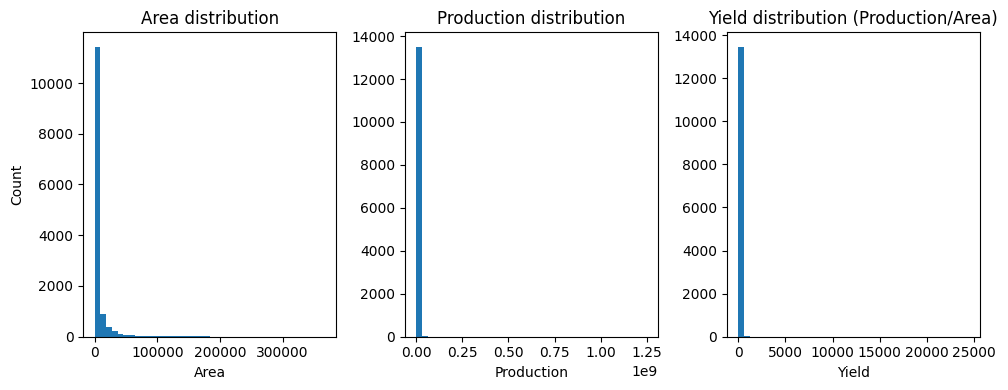

In [14]:
# Cell 7: Univariate plots
plt.rcParams.update({'figure.max_open_warning': 0})
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(df['Area'].dropna(), bins=40)
plt.title('Area distribution')
plt.xlabel('Area')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(df['Production_filled'].dropna(), bins=40)
plt.title('Production distribution')
plt.xlabel('Production')

plt.subplot(1,3,3)
plt.hist(df['Yield_filled'].dropna(), bins=40)
plt.title('Yield distribution (Production/Area)')
plt.xlabel('Yield')

plt.tight_layout()
plt.show()


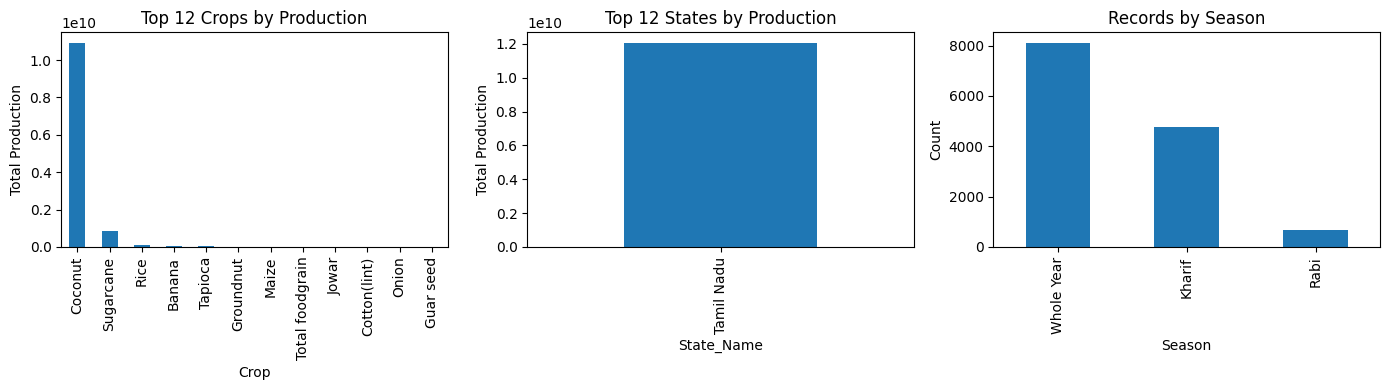

In [15]:
# Cell 8: Top crops, states, seasons by total production
top_n = 12

prod_by_crop = df.groupby('Crop')['Production_filled'].sum().nlargest(top_n)
prod_by_state = df.groupby('State_Name')['Production_filled'].sum().nlargest(top_n)
season_counts = df['Season'].value_counts()

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
prod_by_crop.plot(kind='bar')
plt.title(f'Top {top_n} Crops by Production')
plt.ylabel('Total Production')

plt.subplot(1,3,2)
prod_by_state.plot(kind='bar')
plt.title(f'Top {top_n} States by Production')
plt.ylabel('Total Production')

plt.subplot(1,3,3)
season_counts.plot(kind='bar')
plt.title('Records by Season')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


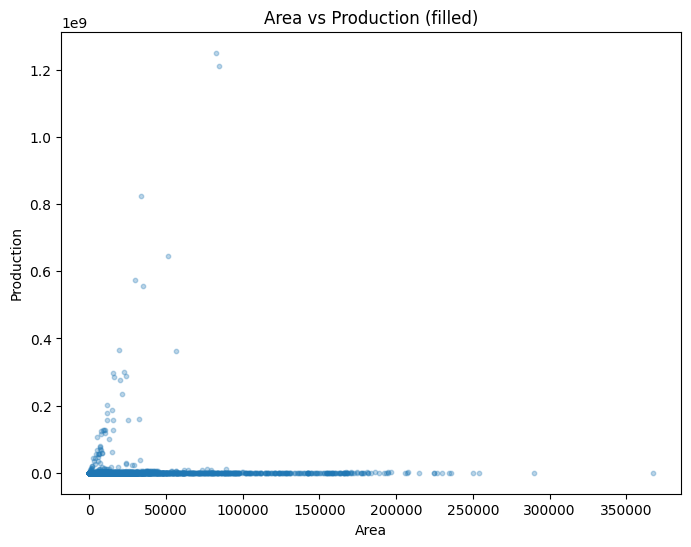

In [16]:
# Cell 9: Area vs Production scatter (and simple linear fit)
x = df['Area'].dropna()
y = df.loc[x.index, 'Production_filled']

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.3, s=10)
plt.xlabel('Area')
plt.ylabel('Production')
plt.title('Area vs Production (filled)')

# Fit a simple linear regression for visualization
mask = (~x.isna()) & (~y.isna())
coeffs = np.polyfit(x[mask], y[mask], 1)
poly = np.poly1d(coeffs)
xx = np.linspace(x.min(), x.quantile(0.95), 100)
plt.plot(xx, poly(xx), linewidth=2)
plt.show()


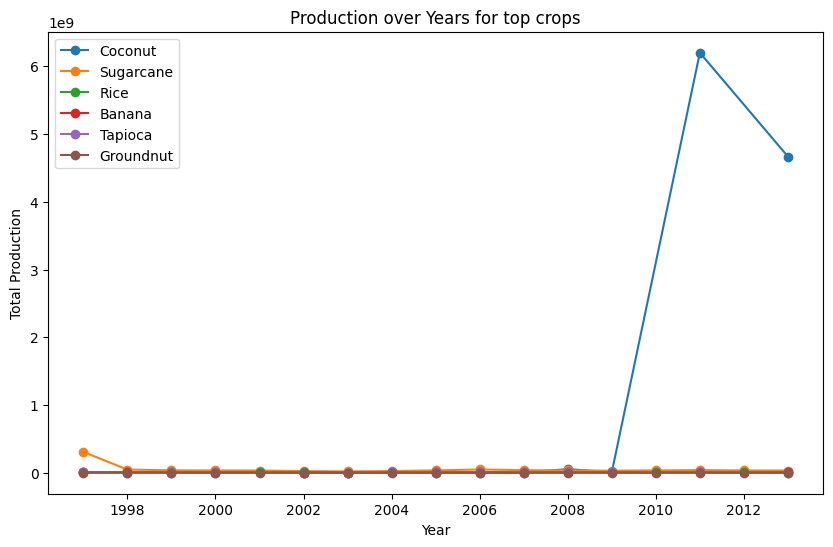

In [17]:
# Cell 10: time-series: production over years for top crops
top_crops = prod_by_crop.index[:6].tolist()  # top 6 crops
plt.figure(figsize=(10,6))
for crop in top_crops:
    s = df[df['Crop'] == crop].groupby('Crop_Year')['Production_filled'].sum()
    plt.plot(s.index, s.values, marker='o', label=crop)
plt.legend()
plt.title('Production over Years for top crops')
plt.xlabel('Year')
plt.ylabel('Total Production')
plt.grid(False)
plt.show()


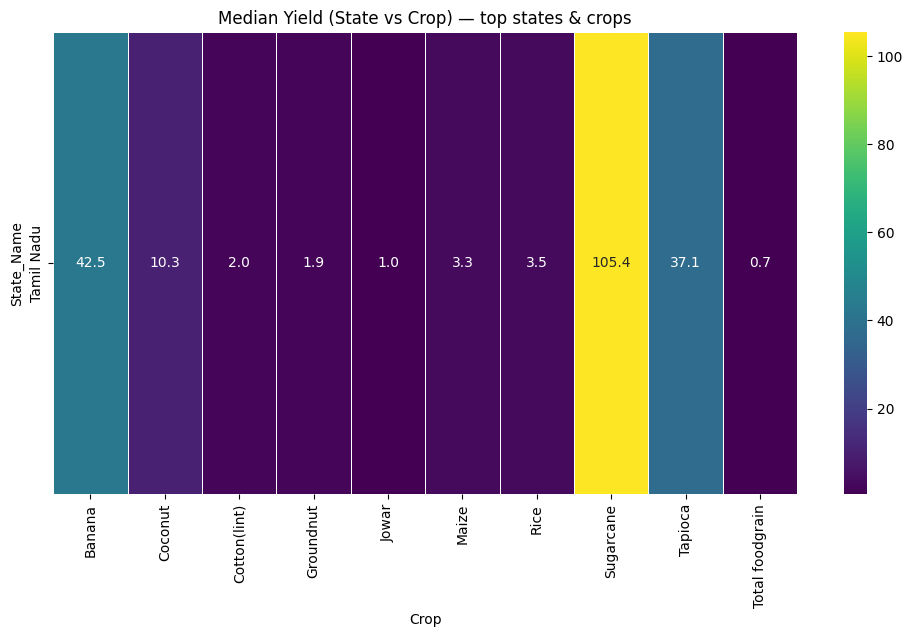

In [18]:
# Cell 11: Heatmap (average yield) for top states & crops (reduce to manageable size)
top_states = df.groupby('State_Name')['Production_filled'].sum().nlargest(10).index.tolist()
top_crops = df.groupby('Crop')['Production_filled'].sum().nlargest(10).index.tolist()

pivot = df[df['State_Name'].isin(top_states) & df['Crop'].isin(top_crops)].pivot_table(
    index='State_Name', columns='Crop', values='Yield_filled', aggfunc='median'
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".1f", linewidths=.5, cmap='viridis')
plt.title('Median Yield (State vs Crop) — top states & crops')
plt.show()


In [19]:
# Cell 12: Feature engineering
model_df = df.copy()

# Use Year as numeric (already Crop_Year)
model_df['Year'] = model_df['Crop_Year'].astype('Int64').astype('float')

# Optionally reduce categories: keep top categories, map others to "Other"
def top_n_map(series, n):
    top = series.value_counts().nlargest(n).index
    return series.where(series.isin(top), other='Other')

model_df['Crop_top'] = top_n_map(model_df['Crop'], 30)
model_df['District_top'] = top_n_map(model_df['District_Name'], 50)
model_df['State_top'] = top_n_map(model_df['State_Name'], 20)
model_df['Season_top'] = model_df['Season'].fillna('Unknown')

# Drop rows where Yield_filled is nan (can't train on missing target)
model_df = model_df[~model_df['Yield_filled'].isna()].copy()
print("Modeling rows available:", model_df.shape[0])


Modeling rows available: 13547


In [23]:
# Cell 13: ML pipeline (predict Yield_filled)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Features and target
features = ['Area', 'Year', 'Crop_top', 'Season_top', 'State_top', 'District_top']
target = 'Yield_filled'
X = model_df[features].copy()
y = model_df[target].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['Area', 'Year']
numeric_transformer = StandardScaler()

categorical_features = ['Crop_top', 'Season_top', 'State_top', 'District_top']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Pipeline with RandomForest
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Fit
print("Fitting model (may take a short while)...")
pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R2:   {r2:.4f}")

# Cross-val (5-fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
print("CV RMSE (5-fold) mean:", -scores.mean(), "std:", scores.std())

# Save model
os.makedirs("models", exist_ok=True)
joblib.dump(pipeline, "models/rf_yield_pipeline.pkl")
print("Saved pipeline to models/rf_yield_pipeline.pkl")


Fitting model (may take a short while)...
Test RMSE: 295.0419
Test MAE:  16.0889
Test R2:   0.8456
CV RMSE (5-fold) mean: 311.8695946971601 std: 41.96326469682159
Saved pipeline to models/rf_yield_pipeline.pkl


In [22]:
# Cell 14: Save processed CSV and create README stub
processed_path = "processed_data.csv"
model_df.to_csv(processed_path, index=False)
print("Saved processed dataset to", processed_path)

readme = """
# Crop Production EDA & Yield Prediction

## Project Overview
- Dataset: Crop production by state/district/year/season/crop
- Notebook: EDA, data cleaning, feature engineering, visualizations, baseline ML model (RandomForest) to predict yield.
- Files:
  - `processed_data.csv` - processed dataset used in modeling
  - `models/rf_yield_pipeline.pkl` - trained pipeline

## Steps to reproduce
1. Open the notebook in VS Code.
2. Run cells in order: data cleaning -> EDA -> modeling.
3. Tweak preprocessing and model hyperparameters as needed.

## Next steps
- Hyperparameter tuning (GridSearch/CV)
- Try XGBoost / LightGBM
- Interpretability (SHAP)
- Build a Streamlit dashboard for interactive viz & predictions
"""

with open("README.md", "w", encoding="utf-8") as f:
    f.write(readme)

print("Wrote README.md")


Saved processed dataset to processed_data.csv
Wrote README.md
